## Exporting and Text Parsing of Drillhole Data
This notebook reads in from an export of the PostGIS/PostgreSQL WAMEX (Western Australian Mineral) database. An export is used in this workshop, instead of directly connecting to the database, for demostration purposes. WAMEX contains mineral exploration reports and data that have lapsed the period of confidentiality. Online access is free of charge at:
https://www.dmp.wa.gov.au/Geological-Survey/Mineral-exploration-Reports-1401.aspx

From this database export, we pullout the following information: <br>
1 ) Collar (CollarID, Longitude, Latitude, RL, MaxDepth) <br>
2 ) Survey (CollarID, Depth, Azimuth, Dip) <br>
3 ) Lithology (CollarID, From_Depth, To_Depth, Company_LithoCode) <br>

The Survey table is further processed to calculate downhole X,Y,Z using minimum curvature.
The Lithology table is further processed to decode the Company Codes into their respective lithologies. These lithologies are then standardized across different drilling campaigns and upscaled to be classified into broader rock types.

## WAMEX Database
Let's take a look at what the database information looks like and how these tables are related:
<a href="./graphics/gswadh_schema.pdf">gswadh_schema.pdf</a>
<img src='./graphics/gswadh_schema.bmp'>
<br>
Today, we will focus on tables necessary for collar, survey and lithology files.
<img src='./graphics/postgres-database.png'>

In [1]:
import pandas as pd
from dh2loop import dh2l

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
%run -i "dh2l_config.py"

Default parameters loaded from dh2l_config.py:
#Database Files
data_path='../data/'
wamex_path='../data/wamex/'
collar_file=wamex_path+'collar.csv'
collarattr_file=wamex_path+'collarattr.csv'
dhsurvey_file=wamex_path+'dhsurvey.csv'
dhsurveyattr_file=wamex_path+'dhsurveyattr.csv'
dhgeology_file=wamex_path+'dhgeology.csv'
dhgeologyattr_file=wamex_path+'dhgeologyattr.csv'

#Thesauri
rl_maxdepth_dic_file= wamex_path+'rl_maxdepth_dic.csv'
survey_dic_file=wamex_path+'survey_dic.csv'
dic_attr_col_lithology_file=wamex_path+'dic_att_col_lithology.csv'
dic_attr_val_lithology_file=wamex_path+'dic_attr_val_lithology_filter.csv'
cleanup_lithology_file=wamex_path+'cleanup_lithology.csv'
litho_dic_file=wamex_path+'litho_dic_1.csv'
CET_hierarchy_dico_file=wamex_path+'hierarchy_dico.csv'

#ExportFiles
export_path='../data/export/'
DB_Collar_Export=export_path+'DB_Collar_Export.csv'
DB_Survey_Export=export_path+'DB_Survey_Export.csv'
DB_Survey_Export_Calc=export_path+'DB_Survey_Export_Calc.csv'
CET_Lith

## Exporting Collar Data

Let's take a look at collar and collarattr table:

In [3]:
collar= pd.read_csv(collar_file,encoding = "ISO-8859-1", dtype='object')
collar.head()

,id,holeid,anumber,companyholeid,dataset,companyid,longitude,latitude,istransformed,modifieddate,modifiedby,mrtfileid,holetype,maxdepth,geom
0,153802,69189Minjar NorthSSRC007,69189,SSRC007,Minjar North,3049,116.949,-28.9058,True,NaN,NaN,5252,RC,127,0101000020E610000000000000C33C5D4000000000E0E7...
1,153803,69189Minjar NorthSSRC008,69189,SSRC008,Minjar North,3049,116.949,-28.9058,True,NaN,NaN,5252,RC,130,0101000020E6100000000000C0C23C5D4000000020E0E7...
2,153804,69189Minjar NorthSSRC009,69189,SSRC009,Minjar North,3049,116.949,-28.9058,True,NaN,NaN,5252,RC,120,0101000020E610000000000000C23C5D4000000040E0E7...
3,153813,69189Minjar NorthSSRC019,69189,SSRC019,Minjar North,3049,116.949,-28.9065,True,NaN,NaN,5252,RC,174,0101000020E610000000000040C03C5D40000000E00FE8...
4,153816,69189Minjar NorthSSRC022,69189,SSRC022,Minjar North,3049,116.949,-28.9068,True,NaN,NaN,5252,RC,146,0101000020E610000000000080C23C5D400000004027E8...


In [4]:
collarattr= pd.read_csv(collarattr_file,encoding = "ISO-8859-1", dtype='object')
collarattr.loc[collarattr['collarid'] == '153802']

,id,collarid,attributecolumn,attributevalue,modifieddate,modifiedby,mrtdetailid
0,1769961,153802,Elevation,359.251,NaN,NaN,116852
1,1769962,153802,TD,127,NaN,NaN,116853
2,1769963,153802,Drilling_code,RC,NaN,NaN,116854
3,1769964,153802,Tenement,M59/421,NaN,NaN,116855
4,1769965,153802,Drill_Date,30-Nov-03,NaN,NaN,116856
6,1769966,153802,Drilling_Company,"""Layne Drilling Pty. Ltd., Perth""",NaN,NaN,116857
7,1769967,153802,HoleDiam,135mm,NaN,NaN,116858
8,1769968,153802,PSI,300,NaN,NaN,116859
9,1769969,153802,Prospect,Silverstone,NaN,NaN,116861


We can see that for drillhole# 153802: <br>
RL = Elevation = 359.251 <br>
MaxDepth = TD =127<br>

Now, let's look at another hole (# 792833):

In [5]:
collarattr.loc[collarattr['collarid'] == '792833']

,id,collarid,attributecolumn,attributevalue,modifieddate,modifiedby,mrtdetailid


We can observe that this time: <br>
RL = RL = 620.20 <br>
MaxDepth = Depth (m) =630.20<br>    

In order to pullout the corresponding RL and MaxDepth values for each drillhole, it was necessary to build a thesaurus.
Here is a quick look into the RL and MaxDepth thesuarus:

In [6]:
rl_maxdepth_dic= pd.read_csv(rl_maxdepth_dic_file,encoding = "ISO-8859-1", dtype='object')
rl_maxdepth_dic.loc[rl_maxdepth_dic['cet_attributecolumn'] == 'rl']

,attributecolumn,cet_attributecolumn
111,"""""""RL""""""",rl
112,"""Nominal\r\nRL """,rl
113,"""RLLocal""",rl
114,"""RLOrig""",rl
115,"""RLSurvMethod""",rl
116,325RL,rl
117,ACC_RL,rl
118,ADJ_RL,rl
119,Adjusted_RL,rl
120,AGD84_RL,rl


In [7]:
rl_maxdepth_dic.loc[rl_maxdepth_dic['cet_attributecolumn'] == 'maxdepth']

,attributecolumn,cet_attributecolumn
0,TD,maxdepth
1,Total depth,maxdepth
2,"""""""DEPTH""""""",maxdepth
3,"""""""TOT_DEPTH""""""",maxdepth
4,"""Final\r\nDepth(m)""",maxdepth
5,"""Hole\r\nDepth""",maxdepth
6,"""Max Depth\r\n metres""",maxdepth
7,"""Max Depth\r\n""",maxdepth
8,AC Depth,maxdepth
9,Actual Depth,maxdepth


Using the thesaurus and a little bit of code and cleaning up, we can extract the collar information.

In [8]:
dh2l.collar_attr_col_dic(rl_maxdepth_dic_file)
dh2l.collar_collarattr_final(collar_file, collarattr_file, rl_maxdepth_dic_file, DB_Collar_Export)
DB_Collar_Export_table=pd.read_csv(DB_Collar_Export,encoding = "ISO-8859-1", dtype='object')
DB_Collar_Export_table= DB_Collar_Export_table.loc[:, ~DB_Collar_Export_table.columns.str.contains('^Unnamed')]
print(DB_Collar_Export_table)

    CollarID                     HoleId Longitude  Latitude       RL MaxDepth
0    1146526   71288Minjar NorthSSDD006   116.948  -28.8991  356.255    546.4
1    1146528   71288Minjar NorthSSDD008   116.947  -28.9021  356.871    405.0
2    1146530   71288Minjar NorthSSDD010   116.949  -28.9083  360.214    249.0
3    1146531   71288Minjar NorthSSDD011   116.948  -28.9002  357.153    468.0
4    1146650   71288Minjar NorthSSDD005   116.948  -28.9002  357.156      150
5    1233095         82655KararaBHN1001   116.818  -29.1504  383.557      108
6    1233096         82655KararaBHN1002   116.818   -29.151  382.505      108
7    1233098         82655KararaKAR1001   116.775  -29.1886  414.225    713.4
8    1233099         82655KararaKAR1002   116.775  -29.1885  414.093    620.2
9    1233100         82655KararaKAR1003   116.774  -29.1913  439.337      200
10   1233101         82655KararaKAR1004   116.775  -29.1913  439.583      186
11   1233102         82655KararaKAR1005   116.776  -29.1913  420

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


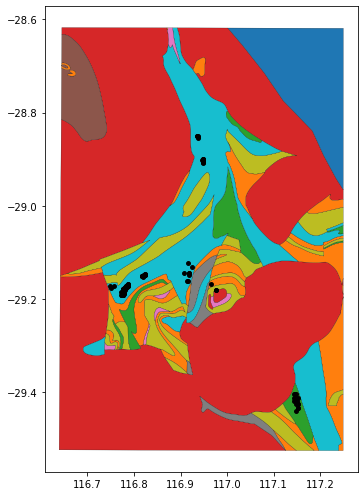

In [9]:
dh2l.plot_collar (DB_Collar_Export, geology)

Let's also calculate for the projected coordinates:

In [10]:
DB_Collar_Export_table = DB_Collar_Export_table.loc[:, ~DB_Collar_Export_table.columns.str.contains('^Unnamed')]
DB_Collar_Export_table[['X','Y']] = DB_Collar_Export_table.apply(dh2l.convert_coords,axis=1)
DB_Collar_Export_table.to_csv(DB_Collar_Export)
print(DB_Collar_Export_table)

    CollarID                     HoleId Longitude  Latitude       RL MaxDepth  \
0    1146526   71288Minjar NorthSSDD006   116.948  -28.8991  356.255    546.4   
1    1146528   71288Minjar NorthSSDD008   116.947  -28.9021  356.871    405.0   
2    1146530   71288Minjar NorthSSDD010   116.949  -28.9083  360.214    249.0   
3    1146531   71288Minjar NorthSSDD011   116.948  -28.9002  357.153    468.0   
4    1146650   71288Minjar NorthSSDD005   116.948  -28.9002  357.156      150   
5    1233095         82655KararaBHN1001   116.818  -29.1504  383.557      108   
6    1233096         82655KararaBHN1002   116.818   -29.151  382.505      108   
7    1233098         82655KararaKAR1001   116.775  -29.1886  414.225    713.4   
8    1233099         82655KararaKAR1002   116.775  -29.1885  414.093    620.2   
9    1233100         82655KararaKAR1003   116.774  -29.1913  439.337      200   
10   1233101         82655KararaKAR1004   116.775  -29.1913  439.583      186   
11   1233102         82655Ka

## Exporting Survey Data

 The same approach is done for survey data.

In [11]:
dhsurvey= pd.read_csv(dhsurvey_file,encoding = "ISO-8859-1", dtype='object')
dhsurvey.loc[dhsurvey['id'] == '1841119']

,id,collarid,depth,units,accuracy,loaddate,loadby,modifieddate,modifiedby,mrtfileid,dip,azimuth


In [12]:
dhsurveyattr= pd.read_csv(dhsurveyattr_file,encoding = "ISO-8859-1", dtype='object')
dhsurveyattr.loc[dhsurveyattr['dhsurveyid'] == '1841119']

,id,dhsurveyid,attributecolumn,attributevalue,loaddate,loadby,modifieddate,modifiedby,mrtdetailid


This time we use a thesaurus to identify Azimuth and Dip readings.

In [13]:
survey_dic= pd.read_csv(survey_dic_file,encoding = "ISO-8859-1", dtype='object')
survey_dic.loc[survey_dic['new_name'] == 'AZI']

,attr_col,new_name
0,Aximuth,AZI
1,AZ,AZI
2,AZ_COMET,AZI
3,AZ_Eelya,AZI
4,AZ_MGX_LOC,AZI
5,AZ_Webbs,AZI
6,AZIM,AZI
7,Azim,AZI
8,AZIMUTH,AZI
9,Azimuth,AZI


In [14]:
survey_dic.loc[survey_dic['new_name'] == 'DIP']

,attr_col,new_name
142,Dip,DIP
143,DIP,DIP
144,dip,DIP
145,Dip (deg.),DIP
146,Dip_2,DIP
147,INC,DIP
148,Inclination,DIP
149,DIP (deg.),DIP


In [15]:
dh2l.survey_attr_col_dic(survey_dic_file)
dh2l.survey_final(dhsurvey_file,dhsurveyattr_file, DB_Survey_Export)
dhsurvey= pd.read_csv(DB_Survey_Export,encoding = "ISO-8859-1", dtype='object')
dhsurvey= dhsurvey.loc[:, ~dhsurvey.columns.str.contains('^Unnamed')]
print(dhsurvey)

     CollarID  Depth Azimuth     Dip
0      153802    0.0    90.0   -50.0
1      153802  120.0    90.0   -90.0
2      153803    0.0    90.0   -55.0
3      153803  130.0    90.0   -90.0
4      153804    0.0    90.0   -60.0
5      153804   60.0    90.0   -90.0
6      153804  120.0    90.0   -90.0
7      153813    0.0    90.0   -60.0
8      153813   50.0    90.0   -90.0
9      153813  100.0    90.0   -90.0
10     153813  174.0    90.0   -90.0
11     153816    0.0    90.0   -60.0
12     153816   50.0    90.0   -90.0
13     153816  100.0    90.0   -90.0
14     153816  146.0    90.0   -90.0
15     153834    0.0    90.0   -60.0
16     153834   54.0    90.0   -90.0
17     153834  102.0    90.0   -90.0
18     153834  138.0    90.0   -90.0
19     153835    0.0    90.0   -60.0
20     153835   50.0    90.0   -90.0
21     153835  100.0    90.0   -90.0
22     153835  150.0    90.0   -90.0
23     548917    0.0    89.6  -60.79
24     548917   20.0    90.4   -90.0
25     548917   40.0    93.1   -90.0
2

Let's also calculate the downhole xyz from the depth, azimuth and dip values using the Minimum Curvature Method. It smooths two straight-line segments of the Balanced Tangential Method by using the Ratio Factor (RF = 2*tan(dl/2)/dl).

<img src='./graphics/Minimum-Curvature-Method.jpg'>

Where:  
MD = Measured Depth between surveys  
I1 = Inclination (angle) of upper survey in degrees  
I2 = Inclination (angle) of lower in degrees  
Az1= Azimuth direction of upper survey  
Az2 = Azimuth direction of lower survey  
RF = Ratio Factor  
ß  = the dog leg angle.  

Sources:
http://www.drillingformulas.com/minimum-curvature-method/ <br>
https://gis.stackexchange.com/questions/13484/how-to-convert-distance-azimuth-dip-to-xyz <br>
http://www.cgg.com/data//1/rec_docs/2269_MinimumCurvatureWellPaths.pdf`<br>

In [16]:
dh2l.convert_survey(DB_Collar_Export,DB_Survey_Export, DB_Survey_Export_Calc)
dhsurvey_calc= pd.read_csv(DB_Survey_Export_Calc,encoding = "ISO-8859-1", dtype='object')
dhsurvey_calc.dropna()
dhsurvey_calc= dhsurvey_calc.loc[:, ~dhsurvey_calc.columns.str.contains('^Unnamed')]
print(dhsurvey_calc)

     CollarID       Depth     Azimuth         Dip Index              X  \
0      153802    0.000000   90.000000  -50.000000     2  495028.106029   
1      153802    0.000000   90.000000  -50.000000     2  494917.618977   
2      153803    0.000000   90.000000  -55.000000     4  495028.106029   
3      153803    0.000000   90.000000  -55.000000     4  494906.041567   
4      153804    0.000000   90.000000  -60.000000     6  495028.106029   
5      153804    0.000000   90.000000  -60.000000     6  494970.810249   
6      153804   60.000000   90.000000  -90.000000     6  494910.810249   
7      153813    0.000000   90.000000  -60.000000     9  495028.139397   
8      153813    0.000000   90.000000  -60.000000     9  494980.392914   
9      153813   50.000000   90.000000  -90.000000     9  494930.392914   
10     153813  100.000000   90.000000  -90.000000     9  494856.392914   
11     153816    0.000000   90.000000  -60.000000    13  495028.153698   
12     153816    0.000000   90.000000 

## Exporting Lithology Data

In [3]:
dh2l.litho_attr_val_dic(dic_attr_val_lithology_file)
dh2l.litho_dico (litho_dic_file)
dh2l.clean_up (cleanup_lithology_file)
dh2l.litho_attr_val_with_fuzzy (CET_Litho)

In [4]:
dh2l.litho_final (collar_file, dhgeology_file, dhgeologyattr_file, dic_attr_col_lithology_file, CET_Litho, DB_Lithology_Export)

Exporting lithology is a bit more tricky than collar and survey because what we get are rock codes (i.e., BAS, GRA) that have to be further decoded.
Let's breakdown the steps done in the export.

<img src='./graphics/lithology_thesauri.png'>

First, the Company_LithoCodes are pulled out the same way we did for Collar and Survey. We use a thesaurus that lists all the attribute columns that refer to lithology.

The second thesaurus decodes the Company_Litho for the corresponding Company_LithoCode.

In [5]:
dic_att_col_lithology=pd.read_csv(dic_attr_col_lithology_file,encoding = "ISO-8859-1", dtype='object')
print(dic_att_col_lithology)

     attributecolumn
0       lithological
1       lihological 
2                LIT
3               LITH
4               Lith
5             Lith_1
6             LITH_1
7        Lith_1_Code
8          Lith_code
9          lith_code
10         Lith_Code
11        lith_code1
12        Lith_Code1
13    Lith_Qualifier
14  Lith_Quallifier1
15             Lith1
16             LITH1
17         Lith1_100
18         Lith1_101
19         Lith1_Cat
20        LITH1_CODE
21        lith1_code
22        Lith1_code
23        Lith1_Code
24         Lith1Code
25         LITHOLOGY
26         lithology
27         Lithology
28      LITHOLOGY  1
29       Lithology 1
30       Lithology_1
31        LITHOLOGY1
32        Lithology1
33    Main Geol Unit
34    Maj. Lithology
35        Major Rock
36              RCK1
37              rck1
38              Rock
39              ROCK
40            Rock 1
41             Rock1
42             ROCK1
43             rock1
44          ROCKCODE
45          Rockcode
46         Ro

Before performing the fuzzywuzzy matching, the Company_Litho text is cleaned to remove extra symbols and descriptions. This includes mineral names, ages and qualifiers (i.e, dominant, abundant, minor).

In [6]:
cleanup_lithology=pd.read_csv(cleanup_lithology_file,encoding = "ISO-8859-1", dtype='object')
print(cleanup_lithology)

             clean
0         abundant
1       actinolite
2       adcumulate
3         adjacent
4         adularia
5         aegirine
6            agate
7           albite
8         alkaline
9         allanite
10       almandine
11         alunite
12       amorphous
13       amphibole
14    amygdaloidal
15        analcime
16         ancient
17      andalusite
18       andradite
19       anglesite
20         angular
21           angle
22       anhydrite
23        ankerite
24       anorthite
25   anthophyllite
26      anticlinal
27       anticline
28      antigorite
29        antimony
..             ...
552    vermiculite
553       vertical
554           very
555        vesicle
556    vesuvianite
557      violarite
558         violet
559             w.
560           wall
561           wash
562         weakly
563           weak
564      weathered
565           west
566            wet
567          white
568      willemite
569      witherite
570           with
571     wolframite
572   wollas

We use the fuzzywuzzy algorithm to standardize the lithologies. The fuzzywuzzy matching compares the Company_Litho phrase against a master thesaurus. FuzzyWuzzy is a library of Python which is used for string matching. Fuzzy string matching is the process of finding strings that match a given pattern. It uses the Levenshtein Distance to calculate the differences between sequences.

The processor we used to do the matching is: fuzz.token_set_ratio. It tokenize strings, but split the tokens into groups: intersection and remainder before comparing. It is not as strict as a using an exact processor but stricter than a partial match. Having a comprehensive thesaurus allows us this processor to work effectively. For more information on this: https://www.geeksforgeeks.org/fuzzywuzzy-python-library/

Here's the pseudocode:<br>
&emsp; scores=process.extract(Cleaned_Company_Litho, Litho_Dico, scorer=fuzz.token_set_ratio)<br>
&emsp; &emsp; for sc in scores:                     
&emsp; &emsp; &emsp; if(sc[score]>bestmatch): #better than previous best match<br>
&emsp; &emsp; &emsp; &emsp; bestmatch =  sc[score]<br>
&emsp; &emsp; &emsp; &emsp; bestlitho= Litho_Dico[firstword]<br>
&emsp; &emsp; &emsp; &emsp; if(sc[litho]==Cleaned_Company_Litho[last]): #bonus for being last word in phrase<br>
&emsp; &emsp; &emsp; &emsp; bestmatch=bestmatch*1.01<br>
&emsp; &emsp; &emsp; elif (sc[score]==bestmatch): #equal to previous best match<br>
&emsp; &emsp; &emsp; &emsp; if(sc[0]==words[last]): #bonus for being last word in phrase<br>
&emsp; &emsp; &emsp; &emsp; &emsp; bestlitho=Litho_Dico[firstword]<br>
&emsp; &emsp; &emsp; &emsp; &emsp; bestmatch=bestmatch*1.01<br>
<br>
The pseudocode shows that we input the Cleaned_Company_Litho and we parse it through a lithology thesaurus. We take in the score for each iteration and if it is greater than the previous match, it store the score and the first lithology listed in the corresponding lithology thesaurus entry. A bonus is also added to the score if the Cleaned_Company_Litho's last word matches the thesaurus.
<br>
Furthermore, if the match is less than a threshold we set (in this case, 80). The CET_Litho is classified as "Other".

Let's take a look at the Lithology Thesaurus. Each row refers to one entry. Each synonym is separated by a space.

In [7]:
lithology_thesaurus=pd.read_csv(litho_dic_file,encoding = "ISO-8859-1", dtype='object')
lithology_thesaurus[lithology_thesaurus['clean'].str.contains('Banded_iron_formation')]

,clean
244,Banded_iron_formation iron-formationBIF Banded...


Let's take a look at the results:

In [8]:
DB_Lithology_Export_View=pd.read_csv(DB_Lithology_Export,encoding = "ISO-8859-1", dtype='object')
print(DB_Lithology_Export_View)

     Company_ID CollarID FromDepth ToDepth Company_LithoCode  \
0          3050  1146526        23      31                 X   
1          3050  1146526        23      31                 X   
2          3050  1146526        31      32                 X   
3          3050  1146526        31      32                 X   
4          3050  1146526        32      38                 X   
5          3050  1146526        32      38                 X   
6          3050  1146526        38      39                 X   
7          3050  1146526        38      39                 X   
8          3050  1146526        39      42                 X   
9          3050  1146526        39      42                 X   
10         3050  1146526        42      43                 X   
11         3050  1146526        42      43                 X   
12         3050  1146526        43      45                 X   
13         3050  1146526        43      45                 X   
14         3050  1146526        45      

## Upscaling Lithology Data

In [9]:
CET_hierarchy_dico = pd.read_csv(CET_hierarchy_dico_file,encoding = "ISO-8859-1")

In [10]:
dh2l.upscale_litho (DB_Lithology_Export, CET_hierarchy_dico_file, DB_Lithology_Upscaled)
Upscaled_Litho= pd.read_csv(DB_Lithology_Upscaled,encoding = "ISO-8859-1")
Upscaled_Litho.head()

,Unnamed: 0,Company_ID,CollarID,FromDepth,ToDepth,Company_LithoCode,Company_Litho,CET_Litho,Score,Level_3,Level_2,Level_1
0,0,3050,1146526,23.0,31.0,X,unknown rock,rock,101,rock,natural_superficial_ground,surficial
1,1,3050,1146526,31.0,32.0,X,unknown rock,rock,101,rock,natural_superficial_ground,surficial
2,2,3050,1146526,32.0,38.0,X,unknown rock,rock,101,rock,natural_superficial_ground,surficial
3,3,3050,1146526,38.0,39.0,X,unknown rock,rock,101,rock,natural_superficial_ground,surficial
4,4,3050,1146526,39.0,42.0,X,unknown rock,rock,101,rock,natural_superficial_ground,surficial


In [11]:
Upscaled_Litho[Upscaled_Litho['Level_1'] == "igneous"]

,Unnamed: 0,Company_ID,CollarID,FromDepth,ToDepth,Company_LithoCode,Company_Litho,CET_Litho,Score,Level_3,Level_2,Level_1
35,35,3050,1146526,352.80,356.10,As,syenite,syenite,101,syenite,intermediate_coarse-grained crystalline,igneous
36,36,3050,1146530,193.30,197.70,As,syenite,syenite,101,syenite,intermediate_coarse-grained crystalline,igneous
37,37,3050,1146528,76.00,78.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous
38,38,3050,1146528,78.00,80.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous
39,39,3050,1146528,80.00,84.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous
40,40,3050,1146528,93.00,95.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous
41,41,3050,1146528,95.00,96.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous
42,42,3050,1146528,147.00,148.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous
43,43,3050,1146531,17.00,22.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous
44,44,3050,1146531,22.00,23.00,Ac,carbonatite,carbonatite,101,carbonatite,exotic_crystalline,igneous


In [12]:
Upscaled_Litho[Upscaled_Litho['Level_2'] == "ore"]

,Unnamed: 0,Company_ID,CollarID,FromDepth,ToDepth,Company_LithoCode,Company_Litho,CET_Litho,Score,Level_3,Level_2,Level_1
3682,3682,1621,1233109,55.00,64.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3683,3683,1621,1233116,0.00,5.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3684,3684,1621,1233116,100.00,101.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3685,3685,1621,1233121,19.00,20.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3686,3686,1621,1233121,21.00,23.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3687,3687,1621,1233121,23.00,26.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3688,3688,1621,1233121,55.00,58.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3689,3689,1621,1233127,6.00,13.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3690,3690,1621,1233127,13.00,19.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation
3691,3691,1621,1233127,19.00,24.00,S,massive sulphides,massive_sulphide,91,massive_sulphide,ore,mineralisation


In [13]:
Upscaled_Litho[Upscaled_Litho['CET_Litho'] == "granodiorite"]

,Unnamed: 0,Company_ID,CollarID,FromDepth,ToDepth,Company_LithoCode,Company_Litho,CET_Litho,Score,Level_3,Level_2,Level_1
3867,3867,3050,548917,0.0,19.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3868,3868,3050,548917,19.0,27.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3869,3869,3050,548917,27.0,31.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3870,3870,3050,548917,31.0,39.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3871,3871,3050,548917,39.0,41.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3872,3872,3050,548917,41.0,50.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3873,3873,3050,548917,54.0,55.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3874,3874,3050,548917,55.0,60.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3875,3875,3050,548917,65.0,73.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous
3876,3876,3050,548917,73.0,87.0,Fgd,granodiorite,granodiorite,101,granodiorite,felsic_coarse-grained crystalline,igneous


Let's also calculate for the X,Y,Z coordiantes for FromDepth, ToDepth and its midpoint.

In [3]:
dh2l.convert_lithology(DB_Collar_Export, DB_Survey_Export, DB_Lithology_Upscaled, DB_Lithology_Export_Calc)
8
print(DB_Lithology_Export_Calculated)

      Company_ID   CollarID  FromDepth  ToDepth Company_LithoCode  \
0           3049   153802.0      24.00    33.00                VQ   
1           3049   153802.0      24.00    33.00                VQ   
2           3049   153802.0      33.00    37.00                VQ   
3           3049   153802.0      33.00    37.00                VQ   
4           3049   153802.0     100.00   101.00                VQ   
5           3049   153802.0     100.00   101.00                VQ   
6           3049   153803.0      26.00    29.00                VQ   
7           3049   153803.0      26.00    29.00                VQ   
8           3049   153803.0      29.00    40.00                VQ   
9           3049   153803.0      29.00    40.00                VQ   
10          3049   153803.0      40.00    42.00                VQ   
11          3049   153803.0      40.00    42.00                VQ   
12          3049   153804.0      31.00    32.00                VQ   
13          3049   153804.0      3

## Export to VTK

In [15]:
dh2l.intervals2vtk(DB_Lithology_Export_Calc, DB_Lithology_Export_VTK)

Open Paraview to view the VTK files and have some fun!<br>
View VTK file by clicking: <a href="../data/export/YalgooSingletonState.pvsm">here</a>
<br>